 # Notebook 2: Calendar Event Integration

 ## Purpose
 - Merge article dataset with calendar events
 - Create temporal features (day of week, month, year, weekend flags)
 - Calculate holiday proximity features
 - Analyze event-article temporal alignment
 - Visualize publication patterns

 ## Inputs
 - `data/processed/articles_cleaned.csv`
 - `data/processed/calendar_events_cleaned.csv`

 ## Outputs
 - `data/processed/articles_with_events.csv`

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported")

Libraries imported


In [5]:
# Define paths
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

ARTICLES_CLEANED = PROCESSED_DIR / 'articles_cleaned.csv'
CALENDAR_CLEANED = PROCESSED_DIR / 'calendar_events_cleaned.csv'
OUTPUT_FILE = PROCESSED_DIR / 'articles_with_events.csv'

print(f"Paths configured")

Paths configured


 ## 1. Load Cleaned Data

In [6]:
print("Loading cleaned datasets...")
df_articles = pd.read_csv(ARTICLES_CLEANED, parse_dates=['published_date_parsed', 'publication_date'])
df_calendar = pd.read_csv(CALENDAR_CLEANED, parse_dates=['Date'])

print(f"Articles: {len(df_articles):,} rows")
print(f"Calendar: {len(df_calendar):,} rows")

Loading cleaned datasets...
Articles: 49,926 rows
Calendar: 11,323 rows


In [7]:
df_articles.head(2)

,url,title,author,published_date,published_date_parsed,publication_date,publication_year,publication_month,publication_day,modified_date,section,tags,article_text,article_text_cleaned,word_count,word_count_calc,cleaned_word_count,media_name,scrape_date
0,https://indianexpress.com/article/technology/m...,Amazon Great Indian Festival sale: Top deals o...,":Tech DeskNew Delhi |Updated: October 8, 2018 ...",2018-10-08,2018-10-08,2018-10-08,2018.0,10.0,8.0,2018-10-08T22:27:48+05:30,General,NaN,Amazon Great Indian Festival sale:Amazon’s upc...,amazon great festival sale amazon upcoming gre...,896,884,490,THE INDIAN EXPRESS,2018-10-08
1,https://indianexpress.com/article/news-archive...,Cong’s wasteland,"PRANNOY ROY, YOGENDRA YADAV, I P BAJPAI, NAMRA...",2004-03-28,2004-03-28,2004-03-28,2004.0,3.0,28.0,2004-03-28,General,NaN,"A mid-March opinion poll, jointly commissioned...",mid march opinion poll jointly commissioned by...,1067,1049,532,THE INDIAN EXPRESS,2004-03-28


In [8]:
df_calendar.head(2)

,Date,Day,Is_Holiday,Holiday_Name,Holiday_Category,Events_Count,Event_Good_Count,Event_Bad_Count,Event_Sentiment,Event_Texts,Event_Links
0,1995-01-01,Sunday,False,NaN,NaN,3,0,0,neutral,The World Trade Organization comes into being....,https://en.wikipedia.org/wiki/World_Trade_Orga...
1,1995-01-02,Monday,False,NaN,NaN,0,0,0,neutral,NaN,NaN


 ## 2. Prepare for Merging

In [9]:
# Ensure date columns are in the same format
df_articles['merge_date'] = pd.to_datetime(df_articles['publication_date']).dt.date
df_calendar['merge_date'] = pd.to_datetime(df_calendar['Date']).dt.date

print("Date columns aligned for merging")

Date columns aligned for merging


 ## 3. Merge Articles with Calendar Events

In [10]:
print("Merging articles with calendar events...")
df_merged = df_articles.merge(
    df_calendar,
    left_on='merge_date',
    right_on='merge_date',
    how='left'
)

print(f"Merged dataset: {len(df_merged):,} rows")
print(f"Columns: {len(df_merged.columns)}")

Merging articles with calendar events...
Merged dataset: 49,926 rows
Columns: 31


In [11]:
# Check merge quality
articles_with_events = df_merged['Events_Count'].notna().sum()
articles_with_holidays = df_merged['Is_Holiday'].fillna(False).sum()

print(f"\nMerge Statistics:")
print(f"  Articles with events: {articles_with_events:,} ({articles_with_events / len(df_merged) * 100:.1f}%)")
print(f"  Articles on holidays: {articles_with_holidays:,} ({articles_with_holidays / len(df_merged) * 100:.1f}%)")


Merge Statistics:
  Articles with events: 49,926 (100.0%)
  Articles on holidays: 1,917 (3.8%)


 ## 4. Create Temporal Features

In [12]:
print("Creating temporal features...")

# Day of week (0=Monday, 6=Sunday)
df_merged['day_of_week'] = pd.to_datetime(df_merged['publication_date']).dt.dayofweek
df_merged['day_name'] = pd.to_datetime(df_merged['publication_date']).dt.day_name()

# Weekend flag
df_merged['is_weekend'] = df_merged['day_of_week'].isin([5, 6]).astype(int)

# Hour (if timestamp available, otherwise set to noon)
df_merged['hour_of_day'] = pd.to_datetime(df_merged['published_date_parsed']).dt.hour
df_merged['hour_of_day'] = df_merged['hour_of_day'].fillna(12)

# Business hours flag (9 AM - 6 PM)
df_merged['is_business_hours'] = ((df_merged['hour_of_day'] >= 9)
                                  & (df_merged['hour_of_day'] <= 18)).astype(int)

# Week of year
df_merged['week_of_year'] = pd.to_datetime(df_merged['publication_date']).dt.isocalendar().week

# Quarter
df_merged['quarter'] = pd.to_datetime(df_merged['publication_date']).dt.quarter

print("Temporal features created")
print(f"  - day_of_week, day_name")
print(f"  - is_weekend, is_business_hours")
print(f"  - week_of_year, quarter")

Creating temporal features...
Temporal features created
  - day_of_week, day_name
  - is_weekend, is_business_hours
  - week_of_year, quarter


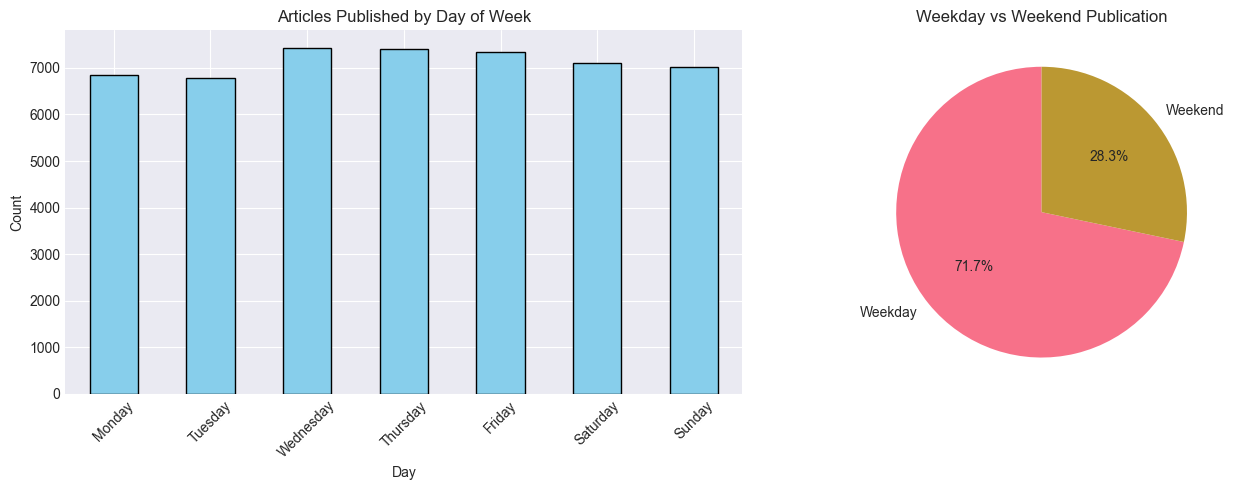

In [13]:
# Visualize day of week distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

day_counts = df_merged['day_name'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
day_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Articles Published by Day of Week')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Weekend vs weekday
weekend_counts = df_merged['is_weekend'].value_counts()
axes[1].pie(weekend_counts, labels=['Weekday', 'Weekend'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Weekday vs Weekend Publication')

plt.tight_layout()
plt.show()


#### Key Insights: Articles by Day & Weekday vs Weekend
1) Most articles are published on weekdays, which account for about 71.7% of all publications, while weekends contribute only 28.3%, indicating a strong weekday publishing bias.

2) Publishing is fairly consistent across individual days, with a slight peak around mid‑week (Wednesday–Thursday) and slightly fewer articles at the start of the week (Monday–Tuesday).

 ## 5. Calculate Holiday Proximity Features

In [14]:
print("Calculating holiday proximity features...")

# Get all holiday dates
holiday_dates = df_calendar[df_calendar['Is_Holiday'] == True]['merge_date'].unique()
holiday_dates_set = set(holiday_dates)


def calculate_holiday_proximity(date):
    """Calculate days to nearest holiday"""
    if pd.isna(date):
        return None, None, None

    date = pd.to_datetime(date).date()

    # Days to nearest holiday (forward and backward)
    min_days_forward = None
    min_days_backward = None

    for holiday in holiday_dates:
        diff = (holiday - date).days

        if diff > 0:  # Future holiday
            if min_days_forward is None or diff < min_days_forward:
                min_days_forward = diff
        elif diff < 0:  # Past holiday
            if min_days_backward is None or abs(diff) < abs(min_days_backward):
                min_days_backward = abs(diff)

    # Nearest holiday (either direction)
    days_to_nearest = None
    if min_days_forward is not None and min_days_backward is not None:
        days_to_nearest = min(min_days_forward, min_days_backward)
    elif min_days_forward is not None:
        days_to_nearest = min_days_forward
    elif min_days_backward is not None:
        days_to_nearest = min_days_backward

    return days_to_nearest, min_days_forward, min_days_backward


# Apply to dataset (sample for speed in demo)
print("  Calculating proximity for all articles...")
proximity_results = df_merged['publication_date'].apply(calculate_holiday_proximity)

df_merged['days_to_nearest_holiday'] = proximity_results.apply(lambda x: x[0])
df_merged['days_to_next_holiday'] = proximity_results.apply(lambda x: x[1])
df_merged['days_from_previous_holiday'] = proximity_results.apply(lambda x: x[2])

# Holiday week flag (within 7 days of holiday)
df_merged['is_holiday_week'] = (df_merged['days_to_nearest_holiday'] <= 7).astype(int)

# Fill missing holiday flags
df_merged['Is_Holiday'] = df_merged['Is_Holiday'].fillna(False).astype(int)

print("Holiday proximity features created")

Calculating holiday proximity features...
  Calculating proximity for all articles...
Holiday proximity features created


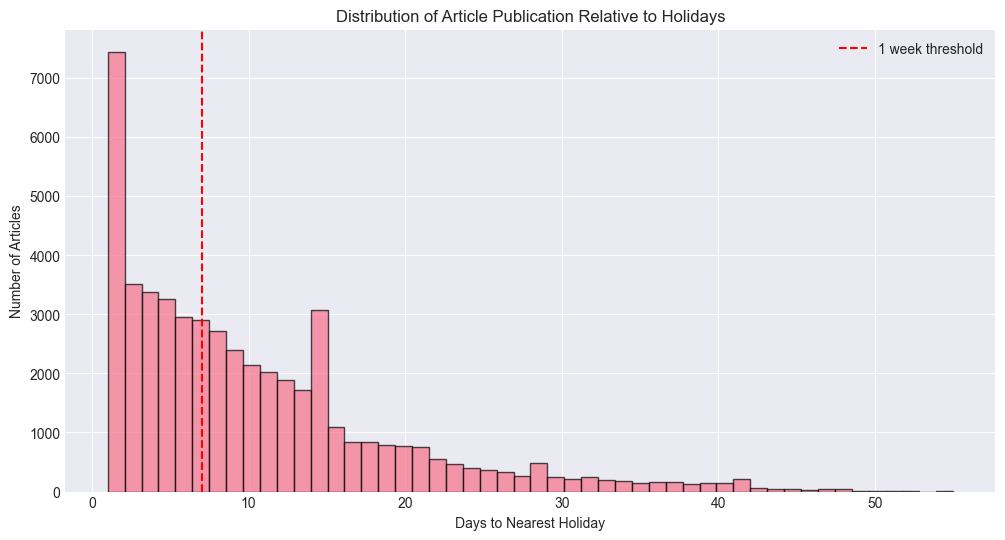

In [15]:
# Visualize holiday proximity distribution
fig, ax = plt.subplots(figsize=(12, 6))
df_merged['days_to_nearest_holiday'].hist(bins=50, ax=ax, edgecolor='black', alpha=0.7)
ax.set_xlabel('Days to Nearest Holiday')
ax.set_ylabel('Number of Articles')
ax.set_title('Distribution of Article Publication Relative to Holidays')
ax.axvline(7, color='red', linestyle='--', label='1 week threshold')
ax.legend()
plt.show()

#### Key Insights: Article Publication Relative to Holidays
1) Articles cluster close to holidays, with the highest counts when the nearest holiday is within just a few days, and a large share falling within the 1‑week threshold marked by the red dashed line.

2) Publication volume drops sharply beyond one week from a holiday, forming a long but thin tail up to ~50 days, suggesting that holiday proximity is a strong driver for many articles but not for all coverage.

 ## 6. Event Features

In [16]:
print("Processing event features...")

# Fill missing event columns
df_merged['Events_Count'] = df_merged['Events_Count'].fillna(0).astype(int)
df_merged['Event_Good_Count'] = df_merged['Event_Good_Count'].fillna(0).astype(int)
df_merged['Event_Bad_Count'] = df_merged['Event_Bad_Count'].fillna(0).astype(int)
df_merged['Event_Sentiment'] = df_merged['Event_Sentiment'].fillna('neutral')

# Event good/bad ratio
df_merged['event_good_bad_ratio'] = np.where(
    df_merged['Event_Bad_Count'] > 0,
    df_merged['Event_Good_Count'] / df_merged['Event_Bad_Count'],
    df_merged['Event_Good_Count']  # If no bad events, use good count
)

# Event sentiment score (-1 to +1)
sentiment_map = {'bad': -1, 'neutral': 0, 'good': 1}
df_merged['event_sentiment_score'] = df_merged['Event_Sentiment'].map(sentiment_map).fillna(0)

# Concurrent events flag
df_merged['has_concurrent_events'] = (df_merged['Events_Count'] > 0).astype(int)

print("Event features created")

Processing event features...
Event features created


In [17]:
# Event statistics
print("\nEvent Statistics:")
print(f"  Days with events: {df_merged['has_concurrent_events'].sum():,}")
print(f"  Total events recorded: {df_merged['Events_Count'].sum():,}")
print(f"  Good events: {df_merged['Event_Good_Count'].sum():,}")
print(f"  Bad events: {df_merged['Event_Bad_Count'].sum():,}")


Event Statistics:
  Days with events: 13,987
  Total events recorded: 19,423
  Good events: 3,264
  Bad events: 9,367


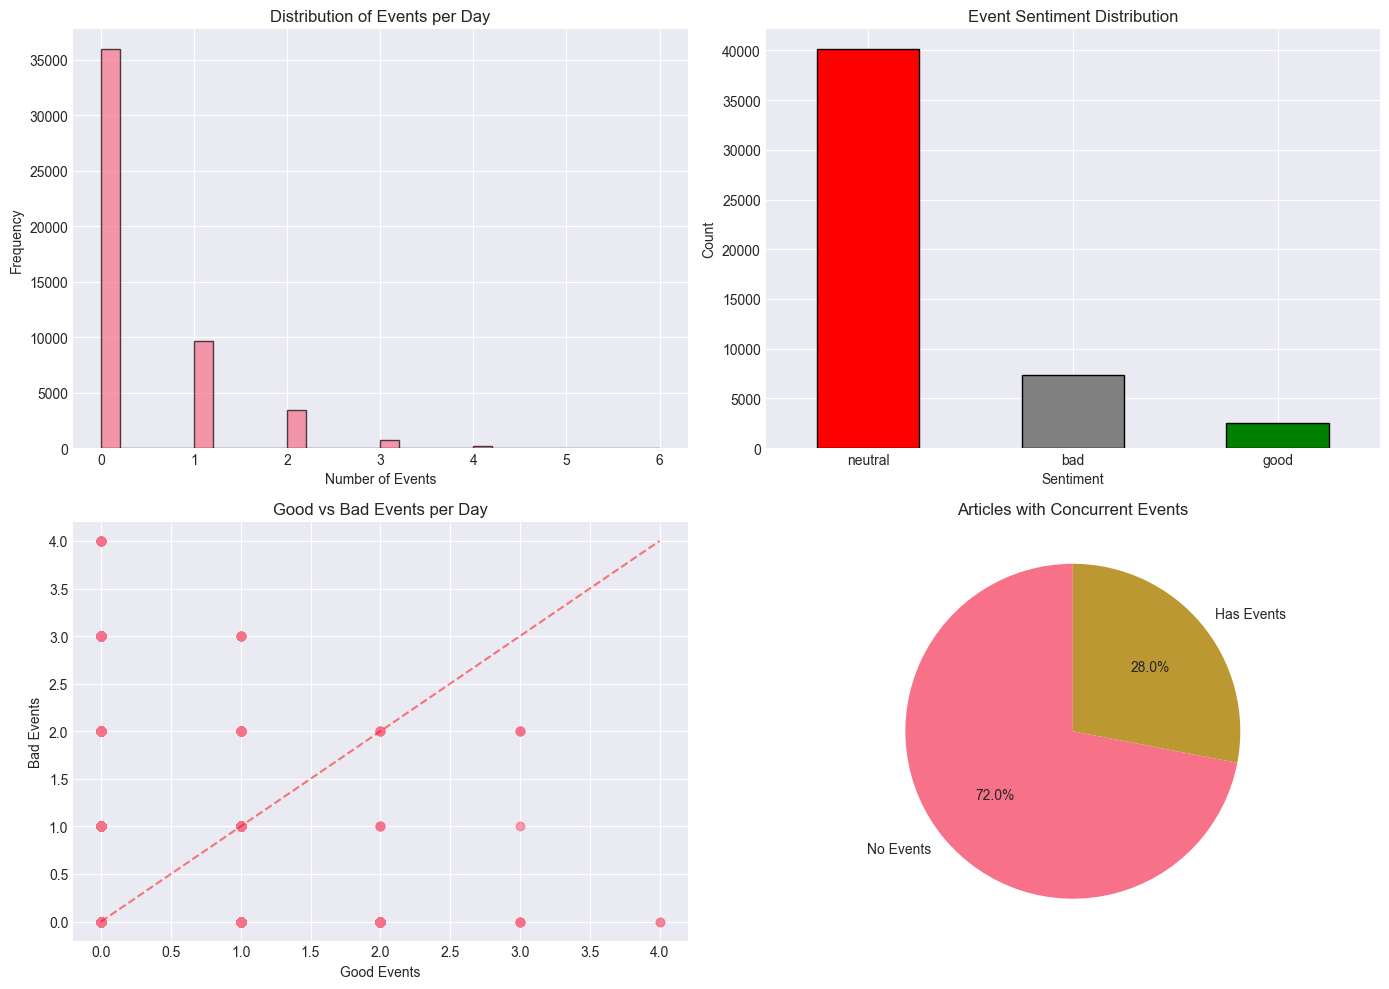

In [18]:
# Visualize event distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Events per day
df_merged['Events_Count'].hist(bins=30, ax=axes[0, 0], edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Events')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Events per Day')

# Event sentiment
sentiment_counts = df_merged['Event_Sentiment'].value_counts()
sentiment_counts.plot(kind='bar', ax=axes[0, 1], color=['red', 'gray', 'green'], edgecolor='black')
axes[0, 1].set_title('Event Sentiment Distribution')
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=0)

# Good vs bad events
axes[1, 0].scatter(df_merged['Event_Good_Count'], df_merged['Event_Bad_Count'], alpha=0.3)
axes[1, 0].set_xlabel('Good Events')
axes[1, 0].set_ylabel('Bad Events')
axes[1, 0].set_title('Good vs Bad Events per Day')
axes[1, 0].plot([0, df_merged['Event_Good_Count'].max()],
                [0, df_merged['Event_Good_Count'].max()], 'r--', alpha=0.5)

# Articles with/without events
event_flag_counts = df_merged['has_concurrent_events'].value_counts()
axes[1, 1].pie(event_flag_counts, labels=['No Events', 'Has Events'], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Articles with Concurrent Events')

plt.tight_layout()
plt.show()

 
#### Key Insights: Events and Sentiment Around Articles
1) Most coverage is not tied to specific events – about 72% of articles have no concurrent events, and on days that do, it is usually just 1 event, with multiple events per day being rare.

2) When events occur, they are mainly neutral or negative – neutral events dominate the sentiment distribution, and among non‑neutral ones, bad events outnumber good events on many days.

 ## 7. Publication Frequency Analysis

In [19]:
print("Analyzing publication frequency...")

# Daily publication count
daily_counts = df_merged.groupby('publication_date').size().reset_index(name='daily_article_count')
df_merged = df_merged.merge(daily_counts, on='publication_date', how='left')

# Rolling 7-day average
daily_counts['rolling_7d_avg'] = daily_counts['daily_article_count'].rolling(window=7, min_periods=1).mean()
daily_counts['rolling_30d_avg'] = daily_counts['daily_article_count'].rolling(window=30, min_periods=1).mean()

# Merge back
df_merged = df_merged.merge(
    daily_counts[['publication_date', 'rolling_7d_avg', 'rolling_30d_avg']],
    on='publication_date',
    how='left'
)

print("Publication frequency features created")

Analyzing publication frequency...
Publication frequency features created


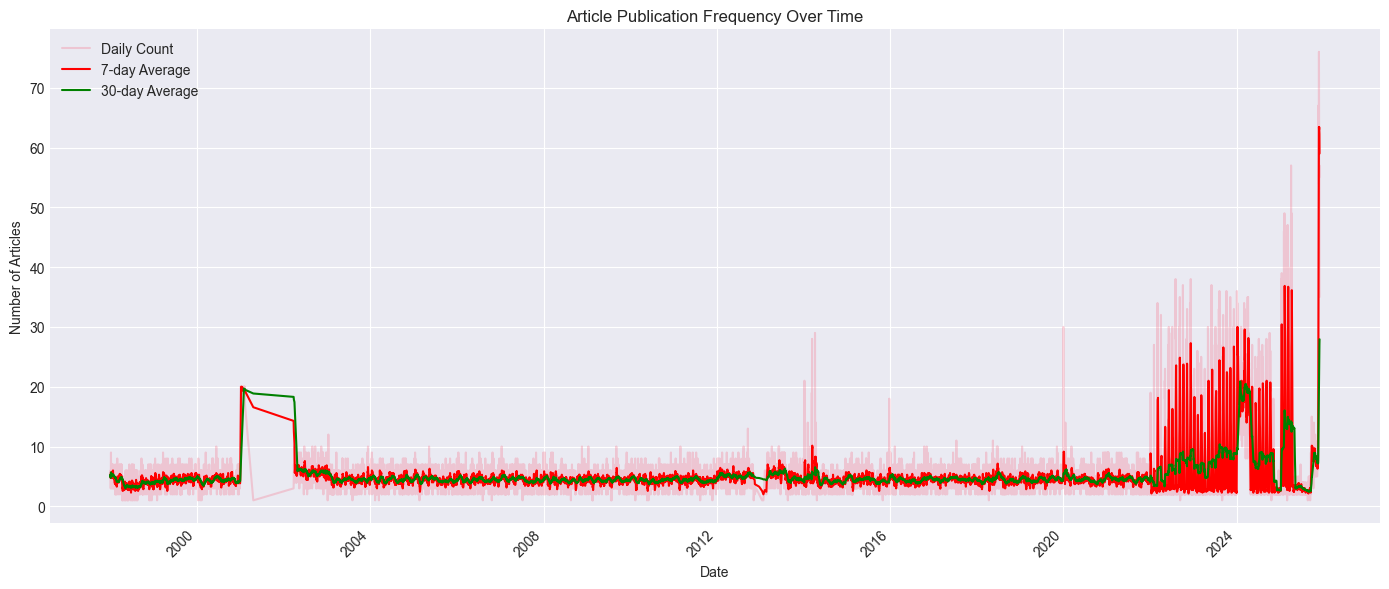

In [20]:
# Visualize publication frequency over time
fig, ax = plt.subplots(figsize=(14, 6))
daily_counts.plot(x='publication_date', y='daily_article_count', ax=ax, alpha=0.3, label='Daily Count')
daily_counts.plot(x='publication_date', y='rolling_7d_avg', ax=ax, color='red', label='7-day Average')
daily_counts.plot(x='publication_date', y='rolling_30d_avg', ax=ax, color='green', label='30-day Average')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Articles')
ax.set_title('Article Publication Frequency Over Time')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Key Insights: Article Publication Frequency Over Time
1) Historical activity is mostly low and steady, with a baseline of around a few articles per day and only brief periods of elevated output in earlier years.

2) Recent years show a sharp rise in both volume and volatility, with much higher daily counts and large spikes, and the 7‑day and 30‑day averages trending well above historical levels, indicating a strong recent expansion in publication.

 ## 8. Data Quality Check

In [21]:
print("=== INTEGRATED DATASET QUALITY CHECK ===\n")
print(f"Total articles: {len(df_merged):,}")
print(f"Total features: {len(df_merged.columns)}")
print(f"\nNew features added: {len(df_merged.columns) - len(df_articles.columns)}")

# Check for missing values in new features
new_features = [
    'day_of_week', 'is_weekend', 'is_holiday_week',
    'days_to_nearest_holiday', 'Events_Count', 'event_sentiment_score'
]

print("\nMissing values in new features:")
for feature in new_features:
    if feature in df_merged.columns:
        missing = df_merged[feature].isna().sum()
        print(f"  {feature}: {missing:,} ({missing / len(df_merged) * 100:.2f}%)")

=== INTEGRATED DATASET QUALITY CHECK ===

Total articles: 49,926
Total features: 48

New features added: 28

Missing values in new features:
  day_of_week: 0 (0.00%)
  is_weekend: 0 (0.00%)
  is_holiday_week: 0 (0.00%)
  days_to_nearest_holiday: 0 (0.00%)
  Events_Count: 0 (0.00%)
  event_sentiment_score: 0 (0.00%)


 ## 9. Save Integrated Dataset

In [22]:
print("\nSaving integrated dataset...")
df_merged.to_csv(OUTPUT_FILE, index=False, encoding='utf-8')

print(f"Saved to: {OUTPUT_FILE}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"  Rows: {len(df_merged):,}")
print(f"  Columns: {len(df_merged.columns)}")


Saving integrated dataset...
Saved to: ../data/processed/articles_with_events.csv
  Size: 240.36 MB
  Rows: 49,926
  Columns: 48


 ## 10. Summary Report

INPUT:
- Articles: 49,926
- Calendar events: 11,323

OUTPUT:
- Integrated articles: 49,926
- New features: 28

TEMPORAL FEATURES:
- Day of week, weekend flags
- Business hours detection
- Week/quarter information

HOLIDAY FEATURES:
- Holiday proximity (nearest, next, previous)
- Holiday week flags
- Articles on holidays: 1,917

EVENT FEATURES:
- Event counts (total, good, bad)
- Event sentiment scores
- Days with events: 13,98